## Analyzing the Impact of Agricultural Policies on Population Health in the United States

<h3> The Problem </h3>


Our aim is to understand if **agricultural policies** in the US are increasing the average calorie intake per person in the US, resulting in increased obesity and decreased population health.
<h3>Population Health</h3>


An ideal <a href="https://en.wikipedia.org/wiki/Population_health">population health</a> outcome metric should reflect a population’s dynamic state of physical, mental, and social well-being. <font color='green'>Positive health</font> outcomes include being **alive**; functioning well **mentally, physically, and socially**; and having a sense of **well-being**. <font color='red'>Negative</font> outcomes include **death**, **loss of function**, and **lack of well-being**. In contrast to these health outcomes, diseases and injuries are intermediate factors that influence the likelihood of achieving a state of health. On the basis of a review of outcomes metrics currently in use and the availability of data for at least some US counties,the following metrics for population health outcomes are recommended: 

1. Life expectancy from birth, or age-adjusted mortality rate.
2. Condition-specific changes in life expectancy, or condition-specific or age-specific mortality rates 
3. Self-reported level of health, functional status, and experiential status. 

When reported, outcome metrics should present both the overall level of health of a population and the distribution of health among different geographic, economic, and demographic groups in the population.

In this project, we use measures such as - 
1. Death Rate by *state*
2. Death Rate due to *endocrine and nutritional issues by state*
3. Obesity Levels by *state and demographics*

as a measure of **poplulation health**.

<h3>Agricultural Policies</h3>

The agricultural policies in the US are generally referred to as <a href="https://www.ers.usda.gov/agricultural-act-of-2014-highlights-and-implications/">farm bill</a>. The latest farm bill was introduced in 2014 and a new bill is due in 2019.

The model the agricultural policies, we use the following variables - 

1. Corn Prices (\$/bushel) by *state*
2. Soybean Prices (\$/bushel) by *state*
3. Subsidies going to corn and soybean productions

In addition to that we will also include the qualitative analysis on the growth of fast food consumption and the price of fast food in the US.

### Importing libraries

In [ ]:
#####################################################################
# Data visualization using Bokeh
#####################################################################
import bokeh
from bokeh.io import show
from bokeh.io import output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper
)
from bokeh.palettes import Viridis6 as palette
from bokeh.palettes import small_palettes as small_palettes
from bokeh.plotting import figure
from bokeh.models import CustomJS, Slider, Legend, LegendItem
from bokeh.layouts import row, widgetbox, gridplot
from bokeh.sampledata.us_states import data as states
from bokeh.models import LinearColorMapper, LinearScale, ColorBar

#####################################################################
# Basic Python libs
#####################################################################

import csv
import sqlite3
import pandas as pd
import numpy as np
import math
import matplotlib

from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import interactive

matplotlib.use("svg")

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

output_notebook()

## The Data Sources

The availability agricultural data is quite abundant and we leveraged several such sources to get our data.

1. Death rate data - <a href="https://wonder.cdc.gov/">Center for Disease Control</a> - 2000 rows
2. Agricultural Data - <a href="https://data.ers.usda.gov/FEED-GRAINS-custom-query.aspx">USDA</a> - 438697 rows
3. Obesity data - <a href="https://catalog.data.gov/dataset?tags=obesity"> DATA.gov</a> - 53392 rows


### Unix Area

In [94]:
datadir = "../data/"
!ls -lrt ../data

total 416400
-rw-r--r--@ 1 rohansingh  staff  81131198 Mar  9 08:49 FeedGrains.csv
-rw-r--r--@ 1 rohansingh  staff   4773458 Apr 12 00:18 FeedGrains.zip
-rw-r--r--  1 rohansingh  staff  79233024 Apr 12 00:28 feedgrain.db
-rw-r--r--  1 rohansingh  staff         0 Apr 12 01:01 FeedGrains.db
-rw-r--r--@ 1 rohansingh  staff    151999 Apr 16 21:47 Analysis_Tableau.twb
-rw-r--r--@ 1 rohansingh  staff     64517 Apr 16 22:30 Analysis_Tableau_AdCampaign.twb
-rw-r--r--@ 1 rohansingh  staff     37081 Apr 24 20:27 tax_per_operation_by_state_corn.csv
-rw-r--r--@ 1 rohansingh  staff   1607687 May  6 18:16 death_rate_data_1999_2016.txt
-rw-r--r--@ 1 rohansingh  staff     49268 May  6 18:34 death_rate_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff     50546 May  6 19:21 death_nutrional_endocrine_by_state_year.txt
-rw-r--r--@ 1 rohansingh  staff  20397291 May  8 10:24 nutrition_physical_activity_raw.csv.backup
-rw-r--r--  1 rohansingh  staff     58833 May  8 10:31 obesity_data_by_state_year.csv
-rw-

### Cleaning the data retrieved from CDC website.

In [13]:
"""
This subroutine cleans and formats data.
"""
def clean_data(filename, **kwargs):
    """
    Takes a filenane to generate clean data for data retrieved from CDC.
    Args:
        filename : Raw filename downloaded from CDC website
        **kwargs['remove_cols'] : Columns that need to dropped
    Returns:
        df : clean dataframe
    """
    
    df = pd.read_csv(datadir + filename, sep="\t")
    df = df[df['Notes'].isnull()]
    df = df.drop('Notes', axis=1)
    df = df.drop(kwargs['remove_cols'], axis=1)
    # death_rate_data = death_rate_data[death_rate_data['Crude Rate'] != 'Unreliable']
    df['Crude Rate'] = df['Crude Rate'].astype(float)
    df['Year'] = df['Year'].astype(int)
    return df

In [14]:
"""
This subroutine helps visualize a data value for all states and years
"""
def plot_all_states(df):
    """
    Args:
        df(dataframe) : a dataframe consisting of year, state, and value column.
    Outputs:
        plot showing value for all states
    """
    legend = []
    plt.figure(figsize=(15,10))
    for state in df['State'].unique():
        df1 = df[df['State'] == state]
        plt.plot(df1['Year'], df1['Crude Rate'])
        legend.append(state)
    plt.xticks(df['Year'].unique())
    plt.legend(legend,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Death rate by state

We see here that the death rate across states have been fairly constant over the years for all the states. 

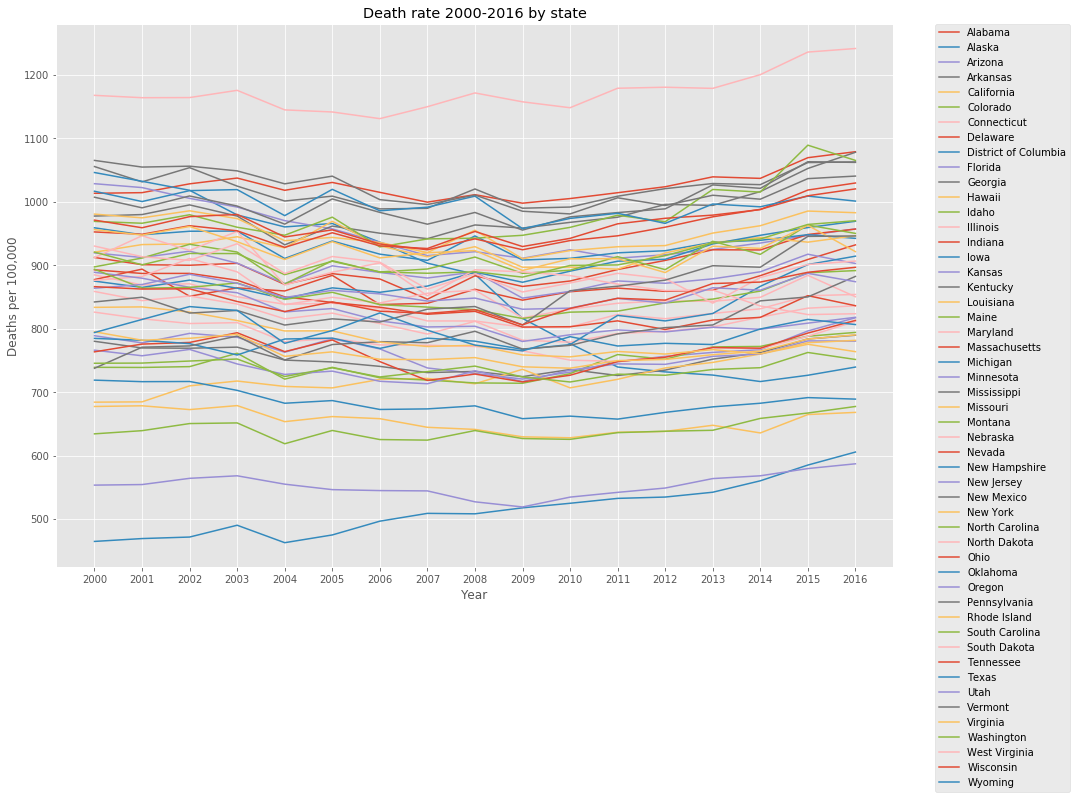

In [15]:
death_rate_state_year = clean_data('death_rate_by_state_year.txt', remove_cols=['State Code', 'Year Code'])
plot_all_states(death_rate_state_year)
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.title("Death rate 2000-2016 by state");

### Death rate by nutrional and endocrine by state

Year       State  Deaths  Population  Crude Rate
0  1999     Alabama  1772.0   4430141.0        40.0
1  1999      Alaska    88.0    624779.0        14.1
2  1999     Arizona  1370.0   5023823.0        27.3
3  1999    Arkansas   967.0   2651860.0        36.5
4  1999  California  8219.0  33499204.0        24.5

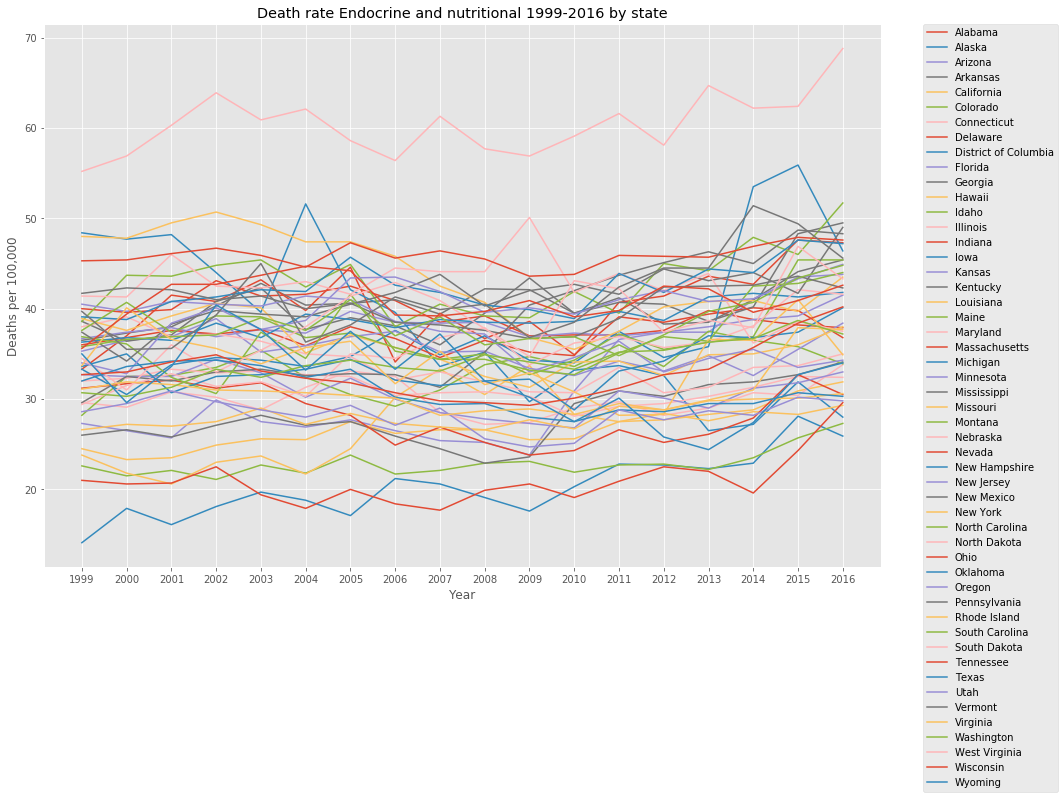

In [16]:
death_nutritional_state_year = clean_data('death_nutrional_endocrine_by_state_year.txt', 
                                          remove_cols=['State Code', 'Year Code'])
plot_all_states(death_nutritional_state_year)
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.title("Death rate Endocrine and nutritional 1999-2016 by state");
death_nutritional_state_year.head()

### Widget to plot each state separately

Next we wanted to delve deeper into data for each state for deaths. For this we created a widget for exploring the statewise data for states using a dropdown menu.

In [17]:
"""
This subroutine is used by an interactive widget to plot the rates given a state.
"""
def plot_state(df,state):
    """
    Args:
        df (dataframe) :  a dataframe consisting of year, state, and value column.
        state : the state for which the interactive plot is shown.
    Outputs:
        Show a matplotlib plot
    """
    min_cr = min(df['Crude Rate'])
    max_cr = max(df['Crude Rate'])
    df1 = df[df['State'] == state]
    plt.plot(df1['Year'], df1['Crude Rate'])
    plt.legend([state])
    plt.xlim(2000,2016)
    plt.ylim(min_cr,max_cr)
    plt.xlabel("Year")
    plt.ylabel("Deaths per 100,000")
    plt.show()
    

### View death rate by state ( Interactivily )

In [18]:
l = [(k,k) for k in death_rate_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_rate_state_year),state=l)
interactive_plot

### View deaths due to nutrition (broad category) 

In [19]:
l = [(k,k) for k in death_nutritional_state_year['State'].unique()]
w = widgets.Select(options=l,description='Select State:')
state = 'Alabama'
    
interactive_plot = interactive(plot_state, df=fixed(death_nutritional_state_year),state=l)
interactive_plot

The interactive map was used to see trends pertaining to states and death rate changes over the years. We found that endocrine and nutrition related deaths have been increasing.

## Visualize state wise data on static map

Next, to see how the data is spread across the United States, we wrote a subroutine to show different rates on a map.
For this task, we utilized the amazing python data visualization library called "Bokeh"

In [158]:
def plot_on_map(df, max_rate=0, min_rate=100, title='Rate'):
    """
    Plot Data on the an interactive US MAP
    """
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
    small_palettes['Reds'][9].reverse()
    states_dict = {
        code: state for code, state in states.items() if str(state).lower() not in EXCLUDED
    }

    state_xs = [states_dict[code]["lons"] for code in states_dict]
    state_ys = [states_dict[code]["lats"] for code in states_dict]
    state_names = [state['name'] for state in states_dict.values()]
    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], high=max_rate, low=min_rate)

    years = np.sort(np.unique(df['Year']))

    rate_years = {str(v): [df[(df['State']==states[state_id]['name']) 
                                   & (df['Year']==v)]['Crude Rate'] for state_id in states] 
                  for i, v in enumerate(years)}
    TOOLS = "pan,wheel_zoom,reset,save"
    size = int(np.ceil(np.sqrt(len(years)+1)))

    cnt = 0

    gridarr = []
    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], low=min_rate, high=max_rate)
    color_bar = ColorBar(color_mapper=color_mapper, 
                 label_standoff=12, border_line_color=None, location=(0,0))
    
    for i in range(size):
        rowarr = []
        for j in range(size):
            if(cnt < len(years)):
                source = ColumnDataSource(data=dict(
                    x=state_xs,
                    y=state_ys,
                    name=state_names,
                    rate=rate_years[str(years[cnt])],
                ))
                p = figure(plot_width=int(900/size), plot_height=int(600/size),title=(title +" "+str(years[cnt])),
                           tools=TOOLS,x_axis_location=None, y_axis_location=None)
                p.grid.grid_line_color = None
                p.patches('x', 'y', source=source,
                          fill_color={'field': 'rate', 'transform': color_mapper},
                          fill_alpha=0.7, line_color="white", line_width=0.5)
                
                rowarr.append(p)
                cnt = cnt + 1
            else:
                rowarr.append(None)
        gridarr.append(rowarr)

    grid = gridplot(gridarr)

    return grid


### Visualizing data over the year on a map

We also figured data to analyze the impact of policies on health, we need a tool to go over years of data and see which places are most affected. This is required for doing a root cause analysis of the problem.

In [31]:
def plot_on_map_with_slider(df, max_rate, min_rate,title="Crude Death Rates"):
    """
    Plot CDC Data on the US Map with year slider
    """
    
    EXCLUDED = ("ak", "hi", "pr", "gu", "vi", "mp", "as")
    
    for state in EXCLUDED:
        if state.upper() in states:
            del states[state.upper()]
            
    small_palettes['Reds'][9].reverse()
    states_dict = {
        code: state for code, state in states.items() if str(state).lower() not in EXCLUDED
    }
    state_xs = [states_dict[code]["lons"] for code in states_dict]
    state_ys = [states_dict[code]["lats"] for code in states_dict]
    
    state_names = [state['name'] for state in states_dict.values()]
    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], high=max_rate, low=min_rate)

    sources = {}
    years = np.sort(np.unique(df['Year']))
    rate_years = {str(v): [df[(df['State']==states[state_id]['name']) 
                               & (df['Year']==v)]['Crude Rate'] for state_id in states] 
              for i, v in enumerate(years)}

    source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    rate=rate_years[str(years[0])],
    **rate_years
))

    TOOLS = "pan,wheel_zoom,reset,save"

    p = figure(
        title=title, tools=TOOLS,
        x_axis_location=None, y_axis_location=None
    )
    p.grid.grid_line_color = None

    p.patches('x', 'y', source=source,
              fill_color={'field': 'rate', 'transform': color_mapper},
              fill_alpha=0.7, line_color="white", line_width=0.5)

    color_mapper = LinearColorMapper(palette=small_palettes['Reds'][9], low=min_rate, high=max_rate)
    color_bar = ColorBar(color_mapper=color_mapper, 
                 label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'right')
    

    callback = CustomJS(args=dict(source=source), code="""
        var year = year.value;
        var data = source.data;
        var col = ''+year
        data['rate'] = data[col]
        source.change.emit();
    """)

    year_slider = Slider(start=years[0], end=years[-1], value=years[0], step=1,
                        title="Year", callback=callback)
    callback.args["year"] = year_slider

    layout = row([p,year_slider])

    show(layout)


### Change in death rate over years in the US

In [33]:
max_cr = max(death_rate_state_year['Crude Rate'])
min_cr = min(death_rate_state_year['Crude Rate'])
plot_on_map_with_slider(death_rate_state_year, max_cr, min_cr)
# show(plot_on_map(death_nutritional_state_year, max_cr, min_cr))

### Visualizing nutrition and endocrine related deaths

It is noticeable to see that the nutrition and endocrine related deaths have increase a lot since 2014 across several states. Also, the new farm bill was introduced in 2014. This made our **belief stronger** that **farm policies** have some correlation with **polulation health**

In [35]:
max_cr = max(death_nutritional_state_year['Crude Rate'])
min_cr = min(death_nutritional_state_year['Crude Rate'])
plot_on_map_with_slider(death_nutritional_state_year, max_cr, min_cr, title = "Nutrition or Endocrine related deaths")
# show(plot_on_map(death_nutritional_state_year, max_cr, min_cr))

### Obesity Data

Across the United States, more than 33% of the adults are obese and more than 16% of children (aged 2-19) are obese. It is one of the biggest health issues facing the nation with about 70% of the country's officials ranking it as the leading issue in their areas [https://stateofobesity.org/obesity-rates-trends-overview/].

We have selected obesity rates by states as our main indicator for public health. The data has been curated from the Centers for Disease Control and Prevention <a href="www.CDC.gov">website</a>. While there are other factors that affect obesity, as you will see in our analysis below, consumption of high caloric food is a major contributing factor.


#### Analyis of Obesity data

In [49]:
raw_obesity = pd.read_csv(datadir + 'nutrition_physical_activity_raw.csv')

In [47]:
### DO NOT CHANGE THIS CELL ###
def clean_obesity(df):
    """
    This subroutine cleans the nutrition and physical activity report that we get from data.gov
    """
    df = df[df['Data_Value_Footnote'].isnull()]
    df = df.drop(["YearEnd", 'Datasource', 'Class', 'Topic', 'Data_Value_Unit','Data_Value_Type',
                    'Data_Value_Alt', 'Data_Value_Footnote', 'Data_Value_Footnote_Symbol','Low_Confidence_Limit',
                     'High_Confidence_Limit ', 'Sample_Size', 'GeoLocation','ClassID','TopicID',
                      'DataValueTypeID','LocationID'], axis = 1)
    df_us = df[df['Total'] == 'Total']
    df_states = df[df['Total'] != 'Total']
    return df_us, df_states

In [52]:
obesity_us, obesity_states = clean_obesity(raw_obestity)
obesity_states.head()

YearStart LocationAbbr LocationDesc  \
1       2011           AL      Alabama   
2       2011           AL      Alabama   

                                            Question  Data_Value Total  \
1  Percent of adults aged 18 years and older who ...        32.3   NaN   
2  Percent of adults aged 18 years and older who ...        31.8   NaN   

  Age(years) Education  Gender Income Race/Ethnicity QuestionID  \
1        NaN       NaN    Male    NaN            NaN       Q036   
2        NaN       NaN  Female    NaN            NaN       Q036   

  StratificationCategory1 Stratification1 StratificationCategoryId1  \
1                  Gender            Male                       GEN   
2                  Gender          Female                       GEN   

  StratificationID1  
1              MALE  
2            FEMALE

As you can see from the table above, the data is divided into various stratification categories, like gender, education, race, etc. Each stratification category has various criteria for stratification. For example, the category education is divides the population into people based on the maximum level of education that they have received, where as the category gender is only split into males and females.

In [125]:
### Visualizing obesity
## Get obesity data.
obesity_viz = obesity_us[obesity_us['QuestionID'] == 'Q036'].loc[:,['YearStart', 'LocationDesc', 'Data_Value']]
obesity_viz.columns = ['Year', 'State', 'Crude Rate']
obesity_viz['State'] = obesity_viz['State'].apply(lambda x: x.title())
obesity_viz.head()

Year     State  Crude Rate
0    2011   Alabama        32.0
254  2012   Alabama        33.0
340  2013   Alabama        32.4
387  2015  National        28.9
599  2014   Alabama        33.5

### Obesity across the US over years

In [126]:
max_cr = np.max(obesity_viz['Crude Rate'])
min_cr = np.min(obesity_viz['Crude Rate'])
plot_on_map_with_slider(obesity_viz, max_cr, min_cr, title="Obesity over years")

In [159]:
min_cr = min(obesity_viz['Crude Rate'])
max_cr = max(obesity_viz['Crude Rate'])
show(plot_on_map(obesity_viz, max_rate=max_cr, min_rate=min_cr,title="Obesity"))

### Fruit Intake Viz

In [146]:
### Visualizing obesity
## Get obesity data.
fruit_viz = obesity_us[obesity_us['QuestionID'] == 'Q018'].loc[:,['YearStart', 'LocationDesc', 'Data_Value']]
fruit_viz.columns = ['Year', 'State', 'Crude Rate']
fruit_viz['State'] = fruit_viz['State'].apply(lambda x: x.title())
fruit_viz.head()

Year    State  Crude Rate
56    2011  Alabama        43.8
426   2013  Alabama        46.0
741   2011   Alaska        38.7
1101  2013   Alaska        39.7
1414  2011  Arizona        38.0

In [150]:
min_cr = min(fruit_viz['Crude Rate'])
max_cr = max(fruit_viz['Crude Rate'])
show(plot_on_map(fruit_viz, max_rate=max_cr, min_rate=min_cr,title="Less than one time/day Fruit Intake"))

In [53]:
question_map = dict(zip(obesity_states['QuestionID'],obesity_states['Question']))
obesity_states_features = obesity_states.drop(['Question', 'Total'], axis = 1)
question_map

{'Q018': 'Percent of adults who report consuming fruit less than one time daily',
 'Q019': 'Percent of adults who report consuming vegetables less than one time daily',
 'Q036': 'Percent of adults aged 18 years and older who have obesity',
 'Q037': 'Percent of adults aged 18 years and older who have an overweight classification',
 'Q043': 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)',
 'Q044': 'Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week',
 'Q045': 'Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combin

### Create features

In [54]:
obesity_without_states = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                       'StratificationCategoryId1', 'StratificationID1', 
                                                       'LocationDesc', 'YearStart' , 'LocationAbbr'], axis=1)
obesity_states_features = obesity_states_features.drop(['StratificationCategory1', 'Stratification1',
                                                        'StratificationCategoryId1', 'StratificationID1', 
                                                        'LocationDesc'], axis=1)


In [58]:
obesity_features = pd.get_dummies(obesity_states_features)
obesity_features_without_year = obesity_features.drop(['YearStart'], axis=1)
obesity_features_without_year.head()

Data_Value  LocationAbbr_AK  LocationAbbr_AL  LocationAbbr_AR  \
1        32.3                0                1                0   
2        31.8                0                1                0   
3        33.6                0                1                0   
4        32.8                0                1                0   
5        33.8                0                1                0   

   LocationAbbr_AZ  LocationAbbr_CA  LocationAbbr_CO  LocationAbbr_CT  \
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   
5                0                0                0                0   

   LocationAbbr_DC  LocationAbbr_DE       ...         Race/Ethnicity_Other  \
1                0                0       ...                            0   
2                0                0       ...                            0   
3                0                0       ...                            0   
4                0                0       ...                            0   
5                0                0       ...                            0   

   QuestionID_Q018  QuestionID_Q019  QuestionID_Q036  QuestionID_Q037  \
1                0                0                1                0   
2                0                0                1                0   
3                0                0                1                0   
4                0                0                1                0   
5                0                0                1                0   

   QuestionID_Q043  QuestionID_Q044  QuestionID_Q045  QuestionID_Q046  \
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   
5                0                0                0                0   

   QuestionID_Q047  
1                0  
2                0  
3                0  
4                0  
5                0  

[5 rows x 92 columns]

Using one-hot-encoding for statesstratification criterias, we can get a list of features to analyze how obesity is being affected depending on their demographic information.

### Only demographic features

In [77]:
from sklearn.linear_model import LogisticRegression
def log_ref_non_state(df):
    df = pd.get_dummies(df)
    df = df.drop(['QuestionID_Q036','QuestionID_Q037','QuestionID_Q047','QuestionID_Q043','QuestionID_Q046',
                 'QuestionID_Q044','QuestionID_Q046'],axis=1)
    X = df.loc[:, df.columns != 'Data_Value']
    y = df.loc[:,'Data_Value'] 
    
    y = y.apply(lambda x: 0 if x<y.mean() else 1)
    regr = LogisticRegression()
    regr.fit(X, y)
    l_ = regr.coef_
    l_ = np.array(l_).flatten().tolist()
    cols = np.array(X.columns).tolist()
    features_imp = [(ft,wt) for wt,ft in sorted(zip(l_,cols))]
    print(features_imp)
    print(regr.score(X,y))
log_ref_non_state(obesity_without_states)

[('QuestionID_Q019', -1.7323125240982133), ('Gender_Female', -1.0595823974101886), ('Race/Ethnicity_Asian', -0.8672871457122511), ('Age(years)_18 - 24', -0.502890619375364), ('Income_Data not reported', -0.381159097589952), ('Age(years)_25 - 34', -0.26068873894723565), ('Race/Ethnicity_Non-Hispanic White', -0.19519832480152352), ('Education_College graduate', -0.16312689013431658), ('Race/Ethnicity_Other', -0.1320039894554376), ('Income_$50,000 - $74,999', -0.045958194782091864), ('Age(years)_65 or older', -0.03686042252208458), ('Income_$75,000 or greater', -0.03197455915350715), ('Income_$35,000 - $49,999', -0.024987402907291418), ('Race/Ethnicity_2 or more races', -0.024664207036119518), ('Age(years)_35 - 44', -0.018003154618175293), ('Income_$25,000 - $34,999', 0.016879685620446883), ('Race/Ethnicity_Hispanic', 0.042867993822844085), ('Education_Some college or technical school', 0.07027516555113127), ('QuestionID_Q045', 0.09264281335560709), ('Gender_Male', 0.12361844394769285), (

### Interpretation of Logistic Regression output

From the output of logistic regression we can interpret that 

1. Non fruit eaters are more prone to obesity.
2. Less educated people are more prone to obesity.
3. Black people are more obese.
4. Also, females are Asians are less obese.

This data also shows that the **food habits** is one of the most **important factor** affecting **obesity**.

### Corn Price Analysis

From the data visualization below, we can **confidently** say that the price of corn has  **dwindled down** from 2010-2017 with a sharp decrease in 2012. Corn is a major component in High Fructose corn syrup which in turn is a major component in high calorie diet. Our hypothesis here is that - **decreasing corn prices** will **increase the profitability** of **food companies** and they will market high calorie food to the population especially, **low income group**, and hence **increase obesity**.

In [87]:
corn_prices = pd.read_csv(datadir + 'corn_prices_by_state.csv')
corn_prices = corn_prices.drop(['Program', 'State ANSI', 'Data Item'], axis = 1)
corn_prices.columns = ['Year', 'State', 'Crude Rate']
corn_prices['State'] = corn_prices['State'].apply(lambda x:x.title())
corn_prices.head()

Year       State  Crude Rate
0  2017     Alabama        4.00
1  2017     Arizona        4.35
2  2017    Arkansas        3.50
3  2017  California        4.20
4  2017    Colorado        3.35

In [91]:
max_cr = np.max(corn_prices['Crude Rate'])
min_cr = np.min(corn_prices['Crude Rate'])
plot_on_map_with_slider(corn_prices, max_cr, min_cr, title="Corn Prices")

#### Corn prices over the years by state

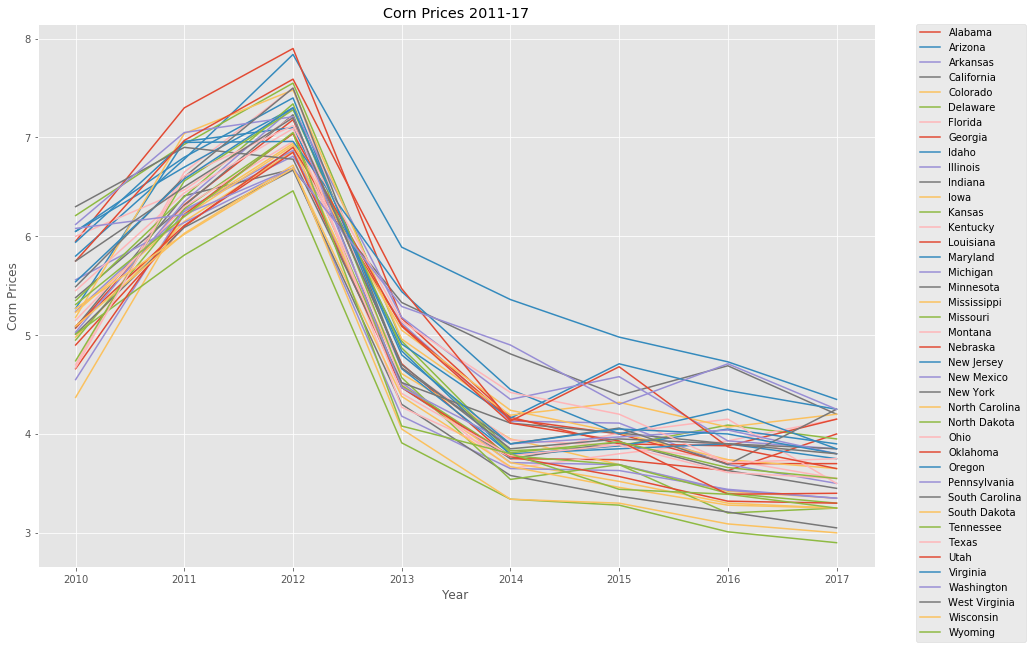

In [93]:
plot_all_states(corn_prices)
plt.xlabel("Year")
plt.ylabel('Corn Prices')
plt.title("Corn Prices 2011-17");

#### Hypothesis Testing - Corn Prices

Next we want to perform a rudimentary **hypothesis test** to check whether the dropping corn prices are correlated with the rise in obesity. We will run this test by performing a **simple, univariate regression** for obesity levels on corn prices.

We are limiting our observations to obesity levels amongst adults.

The equation that we are running is:
\begin{align}
\ ObesityRate_i & = \alpha + \beta \cdot CornPrice_i + \mu_i \\
\end{align}

The null and alternate hypotheses are:
\begin{align}
\ H_0 : \beta & = 0 \\
\ H_A : \beta & < 0 \\
\end{align}

Put into words, our null hypothesis is that corn prices do not affect obesity; whereas the alternate hypothesis is that an increase in corn prices leads to a decrease in obesity, or (for contextual clarity) a decrease in corn prices leads to an increase in obesity.

In [160]:
obesity_hypothesis = obesity_us[obesity_us['QuestionID'] == 'Q036'].loc[:,['YearStart', 'LocationDesc', 'Data_Value']]

In [166]:
obesity_hypothesis.columns = ['Year', 'State', 'Crude Rate']
obesity_hypothesis['State'] = obesity_hypothesis['State'].apply(lambda x: x.title())
obesity_hypothesis.head()

Year     State  Crude Rate
0    2011   Alabama        32.0
254  2012   Alabama        33.0
340  2013   Alabama        32.4
387  2015  National        28.9
599  2014   Alabama        33.5

In [234]:
from scipy.stats import linregress
df_hyp1 = pd.merge(obesity_hypothesis, corn_prices, how='inner',on=['Year', 'State'])
df_hyp1.columns = ['Year', 'State', 'Obesity_level', 'Corn_prices']
linregress(df_hyp1['Corn_prices'], df_hyp1['Obesity_level'])

LinregressResult(slope=-0.6712310777406808, intercept=32.871051260496607, rvalue=-0.2738399862372638, pvalue=1.3203640324917779e-05, stderr=0.15092246244460583)

As we can see the coeffcient of $ \beta $ is comfortably **statistically significant** with at a **significance level of 0.05**.

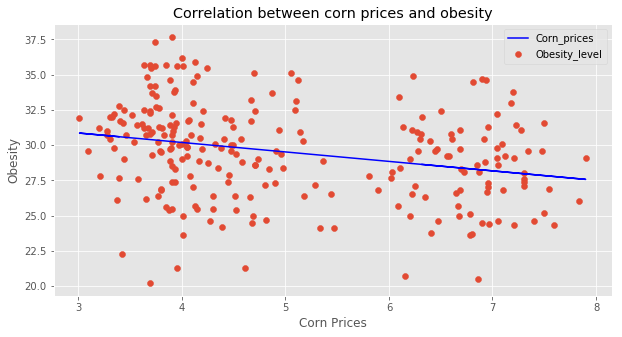

In [239]:
plt.scatter(df_hyp1['Corn_prices'],df_hyp1['Obesity_level'])
plt.plot(df_hyp1['Corn_prices'], -0.6712310777406808*df_hyp1['Corn_prices'] + 32.871051260496607, '-', color='blue')
plt.xlabel("Corn Prices")
plt.ylabel("Obesity")
plt.title("Correlation between corn prices and obesity")
plt.legend();

#### Fixed-Effects Analysis ( Corn - Prices )

Even though, we can see that obesity rises as corn prices fall, we are a little skeptical of these results. The reason for this is **omitted variable bias**. There are a lot of **unobserved variables** that we are not capturing which could be affecting obesity rates in the states.

To reinforce our finding we are running a **Fixed Effects Regression** or Panel Regression. The regression model allows us to include **entity and time fixed effects** which allow us to control for unobserved variables.

The new regression equation is:
\begin{align}
\ ObesityRate_{it} & = \alpha + \beta \cdot CornPrice_{it} + \gamma_i + \theta_t + \mu_{it} \\
\end{align}

Here, the set of fixed effect $ \gamma_i $ control for any variables associated with $ state_i $ that we are not observing and do not change over time. Similarly, the the set of fixed effect $ \theta_t $ control for any variables associated with $ year_t $ that simultaneously affect all states at each time t.

Assuming that our standard errors are **heteroskedastic and correlated for a state over time**, we will **cluster our standard errors**.

In [241]:
from linearmodels.panel import PanelOLS
time = list(df_hyp1['Year'])
entity = list(df_hyp1['State'])
df_hyp1 = df_hyp1.set_index([entity, time])
reg  = PanelOLS(df_hyp1['Corn_prices'],df_hyp1['Obesity_level'],entity_effects=True)
res  = reg.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            Corn_prices   R-squared:                        0.4793
Estimator:                   PanelOLS   R-squared (Between):             -31.600
No. Observations:                 246   R-squared (Within):               0.4793
Date:                Fri, May 11 2018   R-squared (Overall):             -29.480
Time:                        19:16:42   Log-likelihood                   -339.38
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      187.76
Entities:                          41   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                   F(1,204)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             364.68
                            

As we can see, obesity is **negatively correlated** with the price of corn and our findings are **statistically significant**.

### Soybean Price Analysis (Data available for 31 soybean states)

From the data visualization below, we can **confidently** say that the price of soybean has  **dwindled down** from 2009-2017. Soybean is also a component contributing to obesity and is a primary oil source used in frying. Our hypothesis here is that - **decreasing soybean prices** will **increase the profitability** of **food companies** and they will market high fat food to the population especially, **low income group**, and hence **increase obesity**.

In [110]:
soy_prices = pd.read_csv(datadir + 'soyabean_prices_by_state.csv')
len(soy_prices['State'].unique())
# soy_prices = soy_prices[soy_prices['Period']=='MARKETING YEAR']
soy_prices_clean = soy_prices.loc[:,('Year','State', 'Value')]
# soy_prices = soy_prices.drop(['Program', 'State ANSI', 'Data Item'], axis = 1)
soy_prices_clean.columns = ['Year', 'State', 'Crude Rate']
soy_prices_clean['State'] = soy_prices['State'].apply(lambda x:x.title())
soy_prices_clean['Crude Rate'] = soy_prices_clean['Crude Rate'].astype(float)
soy_prices_clean.head()

Year     State  Crude Rate
0  2017   Alabama        9.80
1  2017  Arkansas        9.75
2  2017  Delaware        9.20
3  2017   Florida        8.85
4  2017   Georgia        9.75

In [112]:
max_cr = np.max(soy_prices_clean['Crude Rate'])
min_cr = np.min(soy_prices_clean['Crude Rate'])
plot_on_map_with_slider(soy_prices_clean, max_cr, min_cr, title="Soybean Prices")

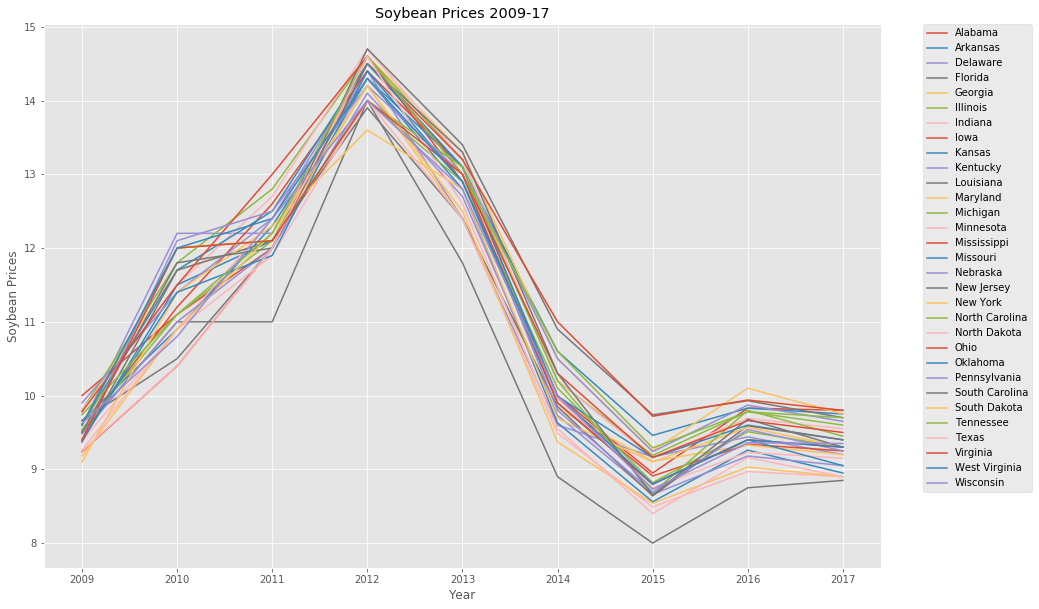

In [115]:
plot_all_states(soy_prices_clean)
plt.xlabel("Year")
plt.ylabel('Soybean Prices')
plt.title("Soybean Prices 2009-17");

#### Hypothesis Testing for Soybean Prices

In [242]:
df_hyp2 = pd.merge(obesity_hypothesis, soy_prices_clean, how='inner',on=['Year', 'State'])
df_hyp2.columns = ['Year', 'State', 'Obesity_level', 'soybean_prices']
linregress(df_hyp2['soybean_prices'], df_hyp2['Obesity_level'])

LinregressResult(slope=-0.26304112628952064, intercept=33.614822749118346, rvalue=-0.18575527902753314, pvalue=0.011135501139344474, stderr=0.10257666809877648)

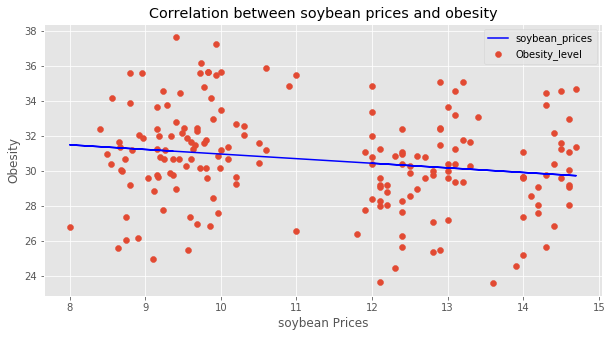

In [244]:
plt.scatter(df_hyp2['soybean_prices'],df_hyp2['Obesity_level'])
plt.plot(df_hyp2['soybean_prices'], -0.26304112628952064*df_hyp2['soybean_prices'] + 33.614822749118346, '-', color='blue')
plt.xlabel("soybean Prices")
plt.ylabel("Obesity")
plt.title("Correlation between soybean prices and obesity")
plt.legend();

#### Fixed-Effects Analysis ( Soybean - Prices )

We did a similar analysis as corn prices for soybean prices and found that **soybean prices** too are **negatively** correlated to obesity levels and the finding are **statistically** significant.

In [243]:
time = list(df_hyp2['Year'])
entity = list(df_hyp2['State'])
df_hyp2 = df_hyp2.set_index([entity, time])
reg  = PanelOLS(df_hyp2['soybean_prices'],df_hyp2['Obesity_level'],entity_effects=True)
res  = reg.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:         soybean_prices   R-squared:                        0.3867
Estimator:                   PanelOLS   R-squared (Between):             -13.449
No. Observations:                 186   R-squared (Within):               0.3867
Date:                Fri, May 11 2018   R-squared (Overall):             -13.045
Time:                        19:22:11   Log-likelihood                   -343.84
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      97.093
Entities:                          31   P-value                           0.0000
Avg Obs:                       6.0000   Distribution:                   F(1,154)
Min Obs:                       6.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             160.14
                            

### Conclusion

The United States agricultural policies are directed towards **reducing** the price of **corn and soybean** as a result of extensive lobbying by big corporations such as **Mosanto**. This reduced prices help them produce high calorie diet. Consumers can **buy** this **high calorie** for an amount **much smaller** than healthy options such as fruits and vegetables. 

This creates a vicisious cycle of issues for the population. Our analysis shows that the decreasing prices are highly correlated to population health. 

### Suggestions for policies

1. Decrease subsidies for crops which are majorly consumed by huge corporations.
2. Increase subsidies on healtier food options such as green vegetables.
3. The food stamp policy should also be directed towards encouraging healthier food options for lower income people.
4. Schools should educate the children at an young age about food and calorie issues. As, educated people are less prone to obesity, the education will help low income group children to understand food and eating habits.